# Mining RNASeq for new MPNST drug targets

## Summary:

This notebook covers our NF Hackathon 2 effort to mine the RNASeq gene expression dataset for possible new drug targets. RNASeq includes a variety of tumor types; we concentrated on CNF. Our strategy was to compare gene expression values between CNF samples and as close as we could get to a control group of normal tissue. We then took the set of genes that appeared "most disrupted" vs. normal, and cross-checked it against Synapese's Drug Target Explorer. We found that a high proportion of this "most disrupted" gene set appeared in the Drug Target Explorer as having known associations with copper. This seems intriguing - while copper is apparently novel in the NF1/CNF context it has a well-established role in many disease processes - notably, it appears heavily involved in angiogenesis and tumor formation, likely through a variety of pathways. A number of drugs are used to reduce copper levels (ex. in Wilson's disease), including penicillamine and TM (tetrathiomolybdate); TM has also been investigated for cancer treatment. Perhaps this suggests a direction for drug development that could work on a number of pathways simultaneously, and possibly be synergistic with other drug approaches. For more details and references, see the readme file.



## Import libraries and retrieve the RNASeq dataset from Synapse:

In [53]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [95]:
from copy import deepcopy

In [1]:
import os
use_saved = os.path.exists('rnaseq.pkl')
if not use_saved :
    import synapseclient
    syn = synapseclient.Synapse()
    ## log in using username and password
    syn.login()

In [2]:
import collections
import csv
import itertools
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.style as style
style.use('ggplot')
#style.use('Solarize_Light2')
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
from pylab import *

# ignore FutureWarning that may pop up when plotting
import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings()

from dfply import *

# For PCA
from sklearn.decomposition import PCA

In [3]:
if not use_saved :
    entity = syn.get('syn20449214')
    #entity.id

In [4]:
if not use_saved :
    results = syn.tableQuery("SELECT * FROM syn20449214")
    genes_with_meta = results.asDataFrame()
    genes_with_meta.to_pickle('rnaseq.pkl')

In [5]:
if use_saved :
    genes_with_meta = pd.read_pickle('rnaseq.pkl')

In [6]:
genes_with_meta.columns

Index(['totalCounts', 'Symbol', 'path', 'zScore', 'specimenID', 'parent',
       'individualID', 'assay', 'dataType', 'sex', 'consortium', 'study',
       'diagnosis', 'tumorType', 'species', 'fundingAgency', 'resourceType',
       'nf1Genotype', 'nf2Genotype', 'studyName', 'used', 'age', 'isCellLine',
       'experimentalCondition', 'transplantationType', 'modelOf'],
      dtype='object')

In [7]:
#Clean up data format
genes_with_meta = genes_with_meta.replace(to_replace = "male", value = "Male")
genes_with_meta = genes_with_meta.replace(to_replace = "female", value = "Female")
genes_with_meta = genes_with_meta.rename(columns={'used': 'id'})
genes_with_meta = genes_with_meta.reset_index()
genes_with_meta = genes_with_meta.drop(labels=["index", "path"], axis =1)
#Quality control
#removing any rows or columns with uncompliant values
genes_with_meta = genes_with_meta[genes_with_meta.totalCounts != "Male"]


## A quick look at the data:

In [8]:
print("Contents of the file:")
genes_with_meta.head(3)

Contents of the file:


,totalCounts,Symbol,zScore,specimenID,parent,individualID,assay,dataType,sex,consortium,...,resourceType,nf1Genotype,nf2Genotype,studyName,id,age,isCellLine,experimentalCondition,transplantationType,modelOf
0,136.993,A1BG,-0.226861,patient10tumor1,syn18407530,patient10,rnaSeq,geneExpression,Male,CTF Biobank,...,experimentalData,-/-,unknown,Cutaneous Neurofibroma Data Resource,syn20430744,NaN,NaN,NaN,NaN,Cutaneous Neurofibroma
1,168.454,A1BG,-0.248889,patient10tumor2,syn18407530,patient10,rnaSeq,geneExpression,Male,CTF Biobank,...,experimentalData,-/-,unknown,Cutaneous Neurofibroma Data Resource,syn20430745,NaN,NaN,NaN,NaN,Cutaneous Neurofibroma
2,115.456,A1BG,-0.115625,patient10tumor3,syn18407530,patient10,rnaSeq,geneExpression,Male,CTF Biobank,...,experimentalData,-/-,unknown,Cutaneous Neurofibroma Data Resource,syn20430746,NaN,NaN,NaN,NaN,Cutaneous Neurofibroma


The following table contains detailed descriptions of the metadata variables included in the data file:

Var | Description
--- | --- 
 _id_  |  the synapseIDs of the individual files with raw data
 _specimenID_  |  individual samples
 _species_  |  the source of the specimen
 _age_  |  the age of the patient 
 _Sex_  |  the sex of the patient
 _tumorType_  |  the the type of tumor, can be one of 7 different diagnoses
 _isCellLine_  |  indicates whether the origin tissue was a cell line or a patient
 _study_  |  the specific initiative/consortia that the study was a part of
 _Symbol_  |  the common names of genes 
 _cellCulture_  |  whether the data was obtained from a cell culture experiment or an _in-vivo_ experiment. Many inherent differences exist between _cell culture_ experiments and _in-vivo_ experiments. These differences may need to be taken into account during analysis and interpretation of the data
 _totalCounts_  |  the main measure of expression levels of the gene. _(the values documented here are not corrected for batch/study)_ 
 _zScore_  |  normalized counts (counts for a gene can vary significantly due to technical differences in different studies, so we normalized the counts into a zScore for a comparable measurement between samples for the same gene)

In [9]:
print("Size of the file:")
print(genes_with_meta.shape)

Size of the file:
(7778164, 25)


In [10]:
genes_with_meta['modelOf'].unique()  # tumor types

array(['Cutaneous Neurofibroma', 'Neurofibroma',
       'Malignant Peripheral Nerve Sheath Tumor',
       'Plexiform Neurofibroma', 'normal', 'Low Grade Glioma',
       'High Grade Glioma', 'Meningioma', 'schwannoma', 'NF1 tumor',
       'Malignant peripheral nerve sheath tumor', 'Schwannoma',
       'Ependymoma', 'Ganglioglioma', 'Other'], dtype=object)

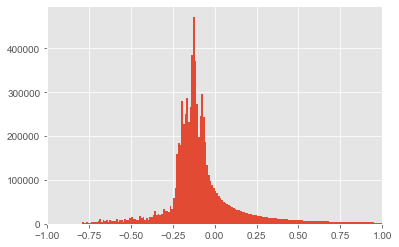

In [11]:
# plot histogram of zScore values
plt.xlim(-1,1)
genes_with_meta.zScore.hist(bins=[0.01*i for i in range(-110,110)]);

In [12]:
def howManyUnique(col,df=None) :
    if df is None : df = genes_with_meta
    return len(df[col].unique())
def howManyWith(col,val,ucols=[]) :
    df = genes_with_meta[genes_with_meta[col] ==val]
    return (len(df),) + tuple(howManyUnique(ucol,df) for ucol in ucols)

Just change this line to MPNST:

In [15]:
complication='Malignant Peripheral Nerve Sheath Tumor'

In [16]:
for ntup in [tup + howManyWith(*tup) for tup in [
      ('modelOf',complication, ['specimenID','individualID']), 
      ('modelOf','normal',['specimenID','individualID']), 
    ]] :
    print(ntup)

('modelOf', 'Malignant Peripheral Nerve Sheath Tumor', ['specimenID', 'individualID'], 345549, 18, 9)
('modelOf', 'normal', ['specimenID', 'individualID'], 1970911, 100, 25)



## Cut down to CNF data and controls derived from normal Schwannn cells:

In [17]:
def grabPartDF(cols,withVals=[],df=None) :
    if df is None : df = genes_with_meta
    partdf = df[cols]
    newCols = list(cols)
    for col,val in withVals :
        partdf = partdf[partdf[col]==val]
        newCols.remove(col)
    return partdf[newCols]
colsL = ['Symbol','specimenID','individualID','zScore','modelOf',]

In [22]:
cnfDF = grabPartDF(colsL,
                   [('modelOf',complication)],
                )
normDF = grabPartDF(colsL,
                   [('modelOf','normal')],
                )


In [23]:
specimens = sorted(cnfDF.specimenID.unique())
individuals = sorted(cnfDF.individualID.unique())
print('CNF dataset: {} specimens, {} individuals'.format(len(specimens),len(individuals)))


CNF dataset: 18 specimens, 9 individuals


**Next we cut the "normal" control dataset down** to two cell lines derived from immortalized normal Schwann cells. This was based on advice from Ray Mattingly and Sarah Gosline that these would make the best controls for comparison. See the readme for more details.

In [24]:
print(sorted(normDF.specimenID.unique())) # all "normal" specimens

['AC027', 'AC028', 'AC029', 'AC029-1', 'AC029-2', 'AC030-1', 'AC030-2', 'AC033-1', 'AC033-2', 'AC033-3', 'AC034', 'AC6-1', 'AC6-2', 'AC7-1', 'AC7-2', 'AC7_A3', 'AC7_A4', 'HS11_1', 'HS11_10', 'HS11_11', 'HS11_12', 'HS11_13', 'HS11_14', 'HS11_15', 'HS11_16', 'HS11_17', 'HS11_18', 'HS11_2', 'HS11_3', 'HS11_4', 'HS11_5', 'HS11_6', 'HS11_7', 'HS11_8', 'HS11_9', 'HSC1L_GATCAG_L002', 'HSC1L_S27', 'MTa450-1', 'MTa450-10', 'MTa450-11', 'MTa450-15', 'MTa450-16', 'MTa450-17', 'MTa450-2', 'MTa450-3', 'MTa450-9', 'MTa451-7', 'MTa451-8', 'MTa451-9', 'N10_S25', 'N15_S3', 'N23_S24', 'N3_S26', 'N87_S23', 'Syn10-1', 'Syn10-2', 'Syn10-3', 'Syn10-4', 'Syn10-5', 'Syn10-6', 'Syn10-7', 'Syn10-8', 'Syn1_1', 'Syn1_10', 'Syn1_11', 'Syn1_12', 'Syn1_13', 'Syn1_14', 'Syn1_15', 'Syn1_16', 'Syn1_17', 'Syn1_18', 'Syn1_19', 'Syn1_2', 'Syn1_20', 'Syn1_21', 'Syn1_22', 'Syn1_23', 'Syn1_24', 'Syn1_3', 'Syn1_4', 'Syn1_5', 'Syn1_6', 'Syn1_7', 'Syn1_8', 'Syn1_9', 'Syn2-1', 'Syn2-2', 'Syn2-3', 'Syn3-1', 'Syn3-2', 'Syn3-3', 'W

In [28]:
normDF = normDF[normDF.specimenID.isin(('ipn02.3','ipn97.4'))] # derived from normal Schwann cells
len(normDF)

38196

In [29]:
set(cnfDF.Symbol.unique())==set(normDF.Symbol.unique()), # sanity check

(True,)

In [30]:
normDF.head()

,Symbol,specimenID,individualID,zScore
1170500,A1BG,ipn02.3,NaN,-0.172290
1170501,A1BG,ipn97.4,NaN,-0.233391
1170517,A1CF,ipn02.3,NaN,-0.190585
1170518,A1CF,ipn97.4,NaN,-0.242574
1170534,A2M,ipn02.3,NaN,-0.178365



## Calculate "most disturbed" genes

In [31]:
normMeanDF = normDF.groupby(['Symbol']).mean() # average zScore values for each gene on the "normal" set

In [32]:
cnfDF.shape,normDF.shape,normMeanDF.shape

((345549, 4), (38196, 4), (19098, 1))

In [33]:
normMeanDF.head()

,zScore
Symbol,
A1BG,-0.202840
A1CF,-0.216580
A2M,-0.181888
A2ML1,-0.216443
A3GALT2,-0.216558


In [34]:
normMeanMap = dict(zip(normMeanDF.index,normMeanDF.as_matrix().squeeze()))
# maps gene symbol -> average expression value on the "normal" set

In [35]:
# map gene symbol -> list of absolute difference of zScore between CNF specimens and "normal" average
disturbLMap = dict((sym,[]) for sym in normMeanMap)
for sym,_,_,v in cnfDF.as_matrix() :
    disturbLMap[sym].append(abs(v-normMeanMap[sym]))
def countAllDisturbed(thresh) :
    # count total number of absolute differences above thresh (used for sanity check)
    tot = totLen = 0
    for vs in disturbLMap.values() :
        totLen += len(vs)
        tot += sum(1 if v>=thresh else 0 for v in vs)
    return tot,totLen
def listAllDisturbVals(maxVal=2.0) :
    # sorted list of all absolute differences clipped to maxVal (used for sanity check)
    return sorted(min(v,maxVal) for v in itertools.chain.from_iterable(disturbLMap.values()))  

In [36]:
# map gene symbol -> average absolute difference over CNF specimens, removing the maximal value
disturbMap = dict((sym,[]) for sym in normMeanMap)
for sym,vs in disturbLMap.items() :
    vvs = list(vs)
    vvs.remove(max(vs))
    disturbMap[sym] = sum(vvs)/len(vvs)

**A few sanity checks:**

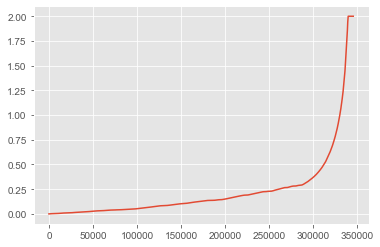

In [37]:
plt.plot(listAllDisturbVals());

In [38]:
countAllDisturbed(0.75)

(21632, 345549)

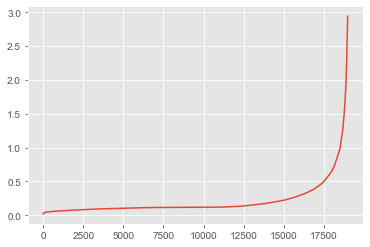

In [39]:
plt.plot(sorted(disturbMap.values())[:-100]);

## Read the Drug Target Explorer data and build a map: target -> list of known associated compounds

In [40]:
def readDrugAssoc(fPath='drug_target_associations_v2.txt') :
    with open(fPath,'r') as f :
        return list(csv.reader(f,delimiter=' '))

In [41]:
drugAssoc = readDrugAssoc()

In [42]:
drugAssocMap = collections.defaultdict(list)
for r in drugAssoc[1:] :
    drugAssocMap[r[1]].append(r[-6])

# Build a heatmap of "most disturbed" genes, annotated with known copper associations

In [43]:
nSyms = 100
syms = sorted(disturbMap.keys(), key=lambda x : disturbMap[x], reverse=True)[:nSyms]
symInd = dict((sym,i) for i,sym in enumerate(syms))

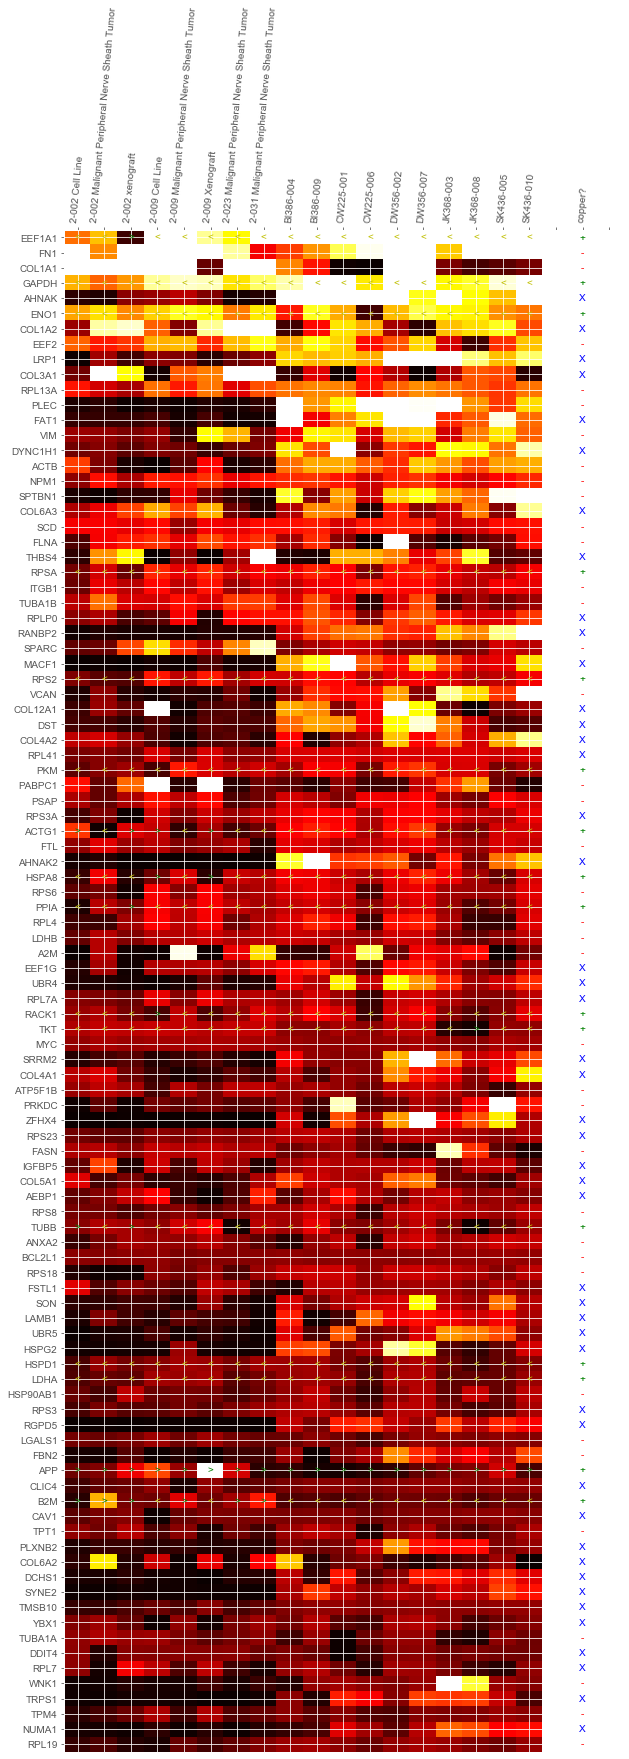

In [71]:
disturbHM = np.zeros((nSyms,len(specimens)+3))
maxHMVal = 20.0
disturbHM[:,-3:] = maxHMVal
y_labels=[]
x_labels=[]
fig,ax = plt.subplots(figsize=(10,28))
#ax.xaxis.grid(False)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(len(disturbHM)))
ax.set_yticklabels(syms)
y_labels=syms
ax.set_xticks(np.arange(len(specimens)+4))
ax.set_xticklabels(specimens + [' ','copper?',' '])
x_labels=specimens + ['_1','copper?','_2']
plt.setp(ax.get_xticklabels(),rotation=85)
totKnown = totCopper = 0
for sym,specimenID,_,v in cnfDF.as_matrix() :
    if sym in symInd :
        i = symInd[sym]
        j = specimens.index(specimenID)
        avgV = normMeanMap[sym]
        disturbHM[i,j] = min(maxHMVal,abs(v-avgV))
        if 'Copper' in drugAssocMap[sym] :
            isHigher = v > avgV
            ax.text(j,i,
                    '>' if isHigher else '<',
                    ha='center',va='center',
                    color='g' if isHigher else 'y')
for i,sym in enumerate(syms) :
    if len(drugAssocMap[sym])==0 :
        ax.text(len(specimens)+1,i,'X',ha='center',va='center',color='b')
    else :
        totKnown += 1
        if 'Copper' in drugAssocMap[sym] :
            totCopper += 1
            ax.text(len(specimens)+1,i,'+',ha='center',va='center',color='g')
        else :
            ax.text(len(specimens)+1,i,'-',ha='center',va='center',color='r')
ax.imshow(disturbHM, cmap='hot', interpolation='nearest', aspect='auto')
plt.savefig('shirinRNA.png')

## copper? column:
## X not in Drug Target Explorer 
## + = in DTE, known association with copper
## - = in DTE, no known association with copper

In [45]:
print('{} of {} ({:.0%}) of "most disturbed" genes in the DTE had known copper associations '
      .format(totCopper,totKnown,totCopper/float(totKnown)))

16 of 54 (30%) of "most disturbed" genes in the DTE had known copper associations 


In [68]:
copperGene=[r for r in drugAssoc if r[-6].lower()=='copper']

In [69]:
totCopper,totKnown = len(copperGene),len(drugAssocMap)
print('{} of {} ({:.0%}) of all target genes in the DTE have a known association with copper'
      .format(totCopper,totKnown,totCopper/float(totKnown)))

144 of 3739 (4%) of all target genes in the DTE have a known association with copper


In [ ]:
mpnst=pd.DataFrame(disturbHM,columns=x_labels)
mpnst.insert(loc=0,column='gene',value=y_labels)

In [97]:
mpnst['has_copper']=['Copper' in drugAssocMap[x] for x in y_labels]

In [98]:
mpnst_cu = deepcopy(mpnst[['gene']+[x for x in x_labels if 'Malignant' in x]+['has_copper']])

In [99]:
mpnst_cu = mpnst_cu[mpnst_cu.has_copper]

In [108]:
mpnst_cu['sum_score']=mpnst_cu.iloc[:,1:5].sum(axis=1)

In [112]:
genes=mpnst_cu.sort_values('sum_score',ascending=False).gene.values

In [113]:
genes

array(['EEF1A1', 'GAPDH', 'ENO1', 'B2M', 'RPSA', 'HSPA8', 'PKM', 'TKT',
       'RACK1', 'PPIA', 'RPS2', 'HSPD1', 'TUBB', 'APP', 'LDHA', 'ACTG1'],
      dtype=object)

In [134]:
drugs=set()
for gene in genes:
    drugs.update(set(drugAssocMap[gene]))

drugs = {x:0 for x in drugs}

for gene in genes:
    for drug in drugAssocMap[gene]:
        drugs[drug] += 1

In [135]:
drugs=list(reversed(sorted([(y,x) for x,y in drugs.items()])))

In [136]:
drugs=[(y,x) for x,y in drugs if y not in ['Copper', 'Zinc'] and x > 1]

In [137]:
drugs

[('Artenimol', 9), ('NSC-119911', 2), ('NADH', 2)]

In [138]:
[gene for gene in genes if drugs[0][0] in drugAssocMap[gene]]

['EEF1A1', 'GAPDH', 'ENO1', 'HSPA8', 'PKM', 'PPIA', 'TUBB', 'LDHA', 'ACTG1']

In [139]:
for drug,count in drugs:
    print(drug, [gene for gene in genes if drug in drugAssocMap[gene]])

Artenimol ['EEF1A1', 'GAPDH', 'ENO1', 'HSPA8', 'PKM', 'PPIA', 'TUBB', 'LDHA', 'ACTG1']
NSC-119911 ['GAPDH', 'HSPA8']
NADH ['GAPDH', 'LDHA']
